# anime-cartoon classification task explanation
Anime and Cartoon both are a form of animation and look almost the same, but there are some structural differences. Although it is hard to explain, human can easily recognize which images are from cartoon class and which images from anime class. We would like to complete a binary-classification task and let the machine classifier these two classes. After that, we will use some visualization methods to explain it and figure out what does the machine mainly focus on.

In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt

C:\Users\daye\.conda\envs\pytorchgpu\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\daye\.conda\envs\pytorchgpu\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#read files
def get_paths_labels(anime_path,cartoon_path):
    anime_img=os.listdir(anime_path)
    cartoon_img=os.listdir(cartoon_path)
    imgpaths=[]
    labels=[]
    for img in anime_img:
        imgpath=anime_path+'/'+img
        imgpaths.append(imgpath)
        labels.append(0)
    for img in cartoon_img:
        imgpath=cartoon_path+'/'+img
        imgpaths.append(imgpath)
        labels.append(1)
    return imgpaths, labels
class Dataset(Dataset):
    def __init__(self, paths, labels):

       
        self.paths = paths
        self.labels = labels

        evalTransform = transforms.Compose(
        [transforms.Resize(256),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.transform = evalTransform
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

#get index img
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), torch.tensor(labels)

In [3]:
test_paths,test_labels=get_paths_labels(anime_path='test/anime',cartoon_path='test/cartoon')
test_dataset=Dataset(test_paths,test_labels)

# Saliency map

In [4]:
# avoid a black image
def normalize(image):
    img_norm=(image-image.min())/(image.max()-image.min())
    return img_norm
def saliency_map(x,y,model):
    model.eval()
    x=x.to(device)
    
    x.requires_grad_() # add pixel information to do gradient
    y_pred=model(x)

    cri=torch.nn.CrossEntropyLoss()
    loss=cri(y_pred,y.to(device))
    loss.backward()

    saliency=x.grad.abs().detach().cpu() #get gradient of x, saliencies dim: [batch,c,h,w]
    saliency=torch.stack([normalize(i) for i in saliency]) 
    #normalize img one by one, avoid an img with big value, another with small value
    return saliency

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
inchannel=model.fc.in_features
model.fc=nn.Linear(inchannel,2)
model.load_state_dict(torch.load('resnet50.pth'),strict=True)
device='cpu'

Using cache found in C:\Users\daye/.cache\torch\hub\pytorch_vision_v0.10.0


# Saliency maps on anime class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


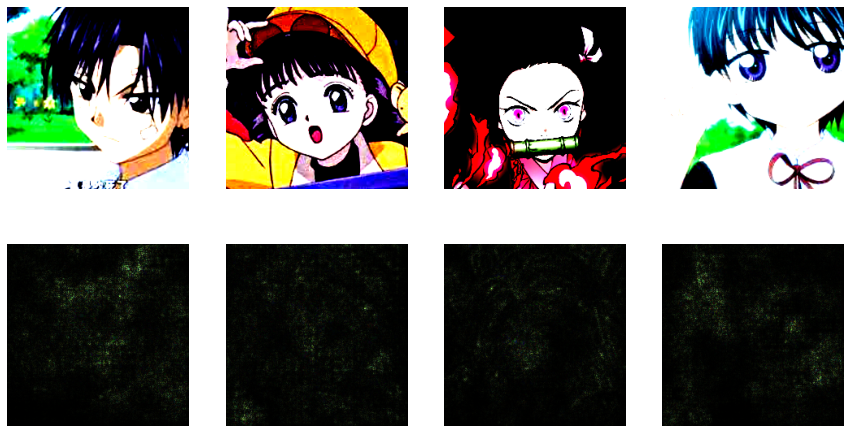

In [16]:
indices=[0,16,11,4]
imgs,labels=test_dataset.getbatch(indices)
saliencies=saliency_map(imgs,labels,model)
fig,axes=plt.subplots(2,4,figsize=(15,8))
for row,target in enumerate([imgs,saliencies]): #1st row: real img, 2nd row: saliency map
    for column,img in enumerate(target):
        #in pytorch,img_dim=[c=3,h=128,w=128]. 
        #in matplotlib, img_dim=[h=128,w=128,c=3],use permute to change dim
        #imshow only numpy.narray type

        axes[row][column].imshow(img.permute(1,2,0).detach().numpy())
        axes[row][column].axis('off')
plt.savefig('Saliency_anime.jpg')
plt.show()
plt.close()

# Saliency maps on cartoon class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


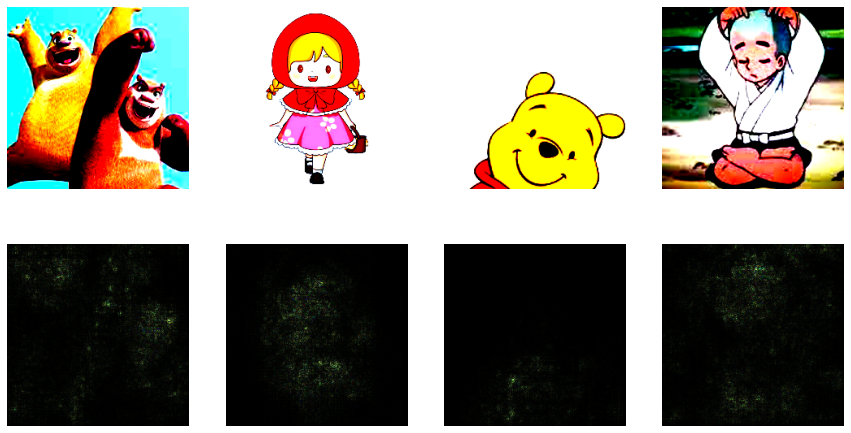

In [15]:
indices=[17,24,32,34]
imgs,labels=test_dataset.getbatch(indices)
saliencies=saliency_map(imgs,labels,model)
fig,axes=plt.subplots(2,4,figsize=(15,8))
for row,target in enumerate([imgs,saliencies]): #1st row: real img, 2nd row: saliency map
    for column,img in enumerate(target):
        #in pytorch,img_dim=[c=3,h=128,w=128]. 
        #in matplotlib, img_dim=[h=128,w=128,c=3],use permute to change dim
        #imshow only numpy.narray type

        axes[row][column].imshow(img.permute(1,2,0).detach().numpy())
        axes[row][column].axis('off')
plt.savefig('Saliency_cartoon.jpg')
plt.show()
plt.close()

# LIME

In [ ]:
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
from skimage.segmentation import mark_boundaries
import numpy as np
device='cpu'
''' step to explain an image model on LIME package
1. Create a predict_fn for CNN network, takes in image and returns a matrix of prediction probabilities
2. Create a segmantation_fn, divide image into 100 segments
3. explainer = lime_image.LimeImageExplainer()
4. explanation = explainer.explain_instance(image, predict_fn, top_labels=5, hide_color=0, num_samples=1000)
---------
Args:
classifier_fn: classifier prediction probability function, which takes a numpy array and outputs prediction probabilities.
top_labels: output the top 5 labels of prediction
hide_color: hide means only show the highlight part, set to 0, the other parts are in gray
num_samples: size of the neighborhood to learn the linear model
---------
5. lime_img,mask=explanation.get_image_and_mask(label=0,positive_only=False,hide_rest=False,num_features=2,min_weight=0.05)
---------
Args:
label:label to explain
positive_only: if True, only take superpixels that positively contribute to the prediction of the label.
hide_rest: if True, make the non-explanation part of the return image gray
num_features: number of superpixels to include in explanation
min_weight: minimum weight of the superpixels to include in explanation
---------
'''
def predict(input):
    #input: numpy array (batch,height,width,channels)
    model.eval()
    input=torch.FloatTensor(input).permute(0,3,1,2) #tensor [batch,c,h,w]
    output=model(input.to(device))
    return output.detach().cpu().numpy()
def segmentation(input):
    #skimage segmente img to 100 components
    return slic(input,n_segments=100,compactness=1,sigma=1)

# LIME on anime class

0


100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


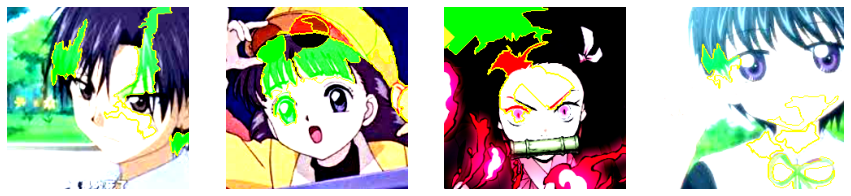

In [24]:
indices=[0,16,11,4]
images,labels=test_dataset.getbatch(indices)
fig,axes=plt.subplots(1,4,figsize=(15,15))
np.random.seed(16)

for idx,(image,label) in enumerate(zip(images.permute(0,2,3,1).numpy(),labels)):
    x=image.astype(np.double)
    print(label.item())
    explainer=lime_image.LimeImageExplainer()
    explanation=explainer.explain_instance(image=x,classifier_fn=predict,segmentation_fn=segmentation,
                                          top_labels=2,hide_color=0,num_samples=1000)
    #classifier_fn define how img through model to prediction
    #segmentation_fn define how to segmente an img
    lime_img,mask=explanation.get_image_and_mask(0,
                                                positive_only=False,
                                                hide_rest=False,
                                                num_features=5,
                                                min_weight=0.05)
    axes[idx].imshow(mark_boundaries(lime_img / 2 + 0.5,mask))
    axes[idx].axis('off')
plt.savefig('LIME_anime.jpg')
plt.show()
plt.close()

# LIME on cartoon class

1


100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


100% |########################################################################|
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


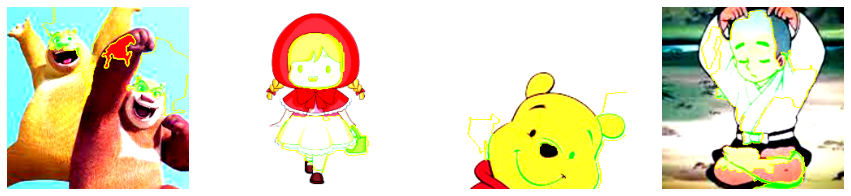

In [23]:
indices=[17,24,32,34]
images,labels=test_dataset.getbatch(indices)
fig,axes=plt.subplots(1,4,figsize=(15,15))
np.random.seed(16)

for idx,(image,label) in enumerate(zip(images.permute(0,2,3,1).numpy(),labels)):
    x=image.astype(np.double)
    print(label.item())
    explainer=lime_image.LimeImageExplainer()
    explanation=explainer.explain_instance(image=x,classifier_fn=predict,segmentation_fn=segmentation,
                                          top_labels=2,hide_color=0,num_samples=1000)
    #classifier_fn define how img through model to prediction
    #segmentation_fn define how to segmente an img
    lime_img,mask=explanation.get_image_and_mask(1,
                                                positive_only=False,
                                                hide_rest=False,
                                                num_features=5,
                                                min_weight=0.05)
    axes[idx].imshow(mark_boundaries(lime_img / 2 + 0.5,mask))
    axes[idx].axis('off')
plt.savefig('LIME_cartoon.jpg')
plt.show()
plt.close()

# Grad -CAM

In [18]:
import cv2
import numpy as np


class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targeted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(
                    self.save_activation))
            # Backward compatibility with older pytorch versions:
            if hasattr(target_layer, 'register_full_backward_hook'):
                self.handles.append(
                    target_layer.register_full_backward_hook(
                        self.save_gradient))
            else:
                self.handles.append(
                    target_layer.register_backward_hook(
                        self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output
        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, grad_input, grad_output):
        # Gradients are computed in reverse order
        grad = grad_output[0]
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu().detach()] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


class GradCAM:
    def __init__(self,
                 model,
                 target_layers,
                 reshape_transform=None,
                 use_cuda=False):
        self.model = model.eval()
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.activations_and_grads = ActivationsAndGradients(
            self.model, target_layers, reshape_transform)

    """ Get a vector of weights for every channel in the target layer.
        Methods that return weights channels,
        will typically need to only implement this function. """

    @staticmethod
    def get_cam_weights(grads):
        return np.mean(grads, axis=(2, 3), keepdims=True)

    @staticmethod
    def get_loss(output, target_category):
        loss = 0
        for i in range(len(target_category)):
            loss = loss + output[i, target_category[i]]
        return loss

    def get_cam_image(self, activations, grads):
        weights = self.get_cam_weights(grads)
        weighted_activations = weights * activations
        cam = weighted_activations.sum(axis=1)

        return cam

    @staticmethod
    def get_target_width_height(input_tensor):
        width, height = input_tensor.size(-1), input_tensor.size(-2)
        return width, height

    def compute_cam_per_layer(self, input_tensor):
        activations_list = [a.cpu().data.numpy()
                            for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy()
                      for g in self.activations_and_grads.gradients]
        target_size = self.get_target_width_height(input_tensor)

        cam_per_target_layer = []
        # Loop over the saliency image from every layer

        for layer_activations, layer_grads in zip(activations_list, grads_list):
            cam = self.get_cam_image(layer_activations, layer_grads)
            cam[cam < 0] = 0  # works like mute the min-max scale in the function of scale_cam_image
            scaled = self.scale_cam_image(cam, target_size)
            cam_per_target_layer.append(scaled[:, None, :])

        return cam_per_target_layer

    def aggregate_multi_layers(self, cam_per_target_layer):
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return self.scale_cam_image(result)

    @staticmethod
    def scale_cam_image(cam, target_size=None):
        result = []
        for img in cam:
            img = img - np.min(img)
            img = img / (1e-7 + np.max(img))
            if target_size is not None:
                img = cv2.resize(img, target_size)
            result.append(img)
        result = np.float32(result)

        return result

    def __call__(self, input_tensor, target_category=None):

        if self.cuda:
            input_tensor = input_tensor.cuda()

        # 正向传播得到网络输出logits(未经过softmax)
        output = self.activations_and_grads(input_tensor)
        if isinstance(target_category, int):
            target_category = [target_category] * input_tensor.size(0)

        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy(), axis=-1)
            print(f"category id: {target_category}")
        else:
            assert (len(target_category) == input_tensor.size(0))

        self.model.zero_grad()
        loss = self.get_loss(output, target_category)
        loss.backward(retain_graph=True)

        # In most of the saliency attribution papers, the saliency is
        # computed with a single target layer.
        # Commonly it is the last convolutional layer.
        # Here we support passing a list with multiple target layers.
        # It will compute the saliency image for every image,
        # and then aggregate them (with a default mean aggregation).
        # This gives you more flexibility in case you just want to
        # use all conv layers for example, all Batchnorm layers,
        # or something else.
        cam_per_layer = self.compute_cam_per_layer(input_tensor)
        return self.aggregate_multi_layers(cam_per_layer)

    def __del__(self):
        self.activations_and_grads.release()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.activations_and_grads.release()
        if isinstance(exc_value, IndexError):
            # Handle IndexError here...
            print(
                f"An exception occurred in CAM with block: {exc_type}. Message: {exc_value}")
            return True


def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.
    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def center_crop_img(img: np.ndarray, size: int):
    h, w, c = img.shape

    if w == h == size:
        return img

    if w < h:
        ratio = size / w
        new_w = size
        new_h = int(h * ratio)
    else:
        ratio = size / h
        new_h = size
        new_w = int(w * ratio)

    img = cv2.resize(img, dsize=(new_w, new_h))

    if new_w == size:
        h = (new_h - size) // 2
        img = img[h: h+size]
    else:
        w = (new_w - size) // 2
        img = img[:, w: w+size]

    return img

# Grad-CAM on anime class

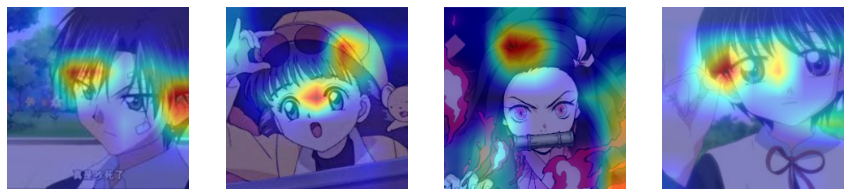

In [19]:
target_layers = [model.layer4]
data_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# load image
indices=[0,16,11,4]
fig,axes=plt.subplots(1,len(indices),figsize=(15,15))
for i,index in enumerate(indices):
    img_path = test_paths[index]
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    img = center_crop_img(img, 224)
    # [C, H, W]
    img_tensor = data_transform(img)
    # expand batch dimension
    # [C, H, W] -> [N, C, H, W]
    input_tensor = torch.unsqueeze(img_tensor, dim=0)


    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    target_category = 0  # anime
    #target_category = 1  # cartoon

    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                  grayscale_cam,
                                  use_rgb=True)
    axes[i].imshow(visualization)
    axes[i].axis('off')
plt.savefig('Cam_anime.jpg')
plt.show()
plt.close()

# Grad-CAM on cartoon class

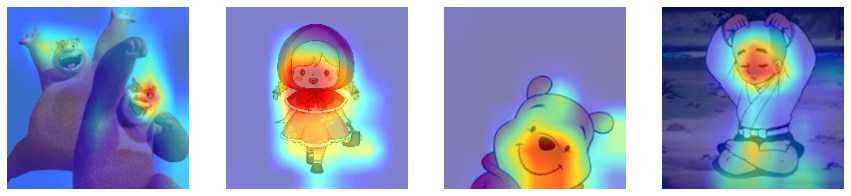

In [21]:
# load image
indices=[17,24,32,34]
fig,axes=plt.subplots(1,len(indices),figsize=(15,15))
for i,index in enumerate(indices):
    img_path = test_paths[index]
    assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
    img = Image.open(img_path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    img = center_crop_img(img, 224)
    # [C, H, W]
    img_tensor = data_transform(img)
    # expand batch dimension
    # [C, H, W] -> [N, C, H, W]
    input_tensor = torch.unsqueeze(img_tensor, dim=0)


    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    #target_category = 0  # anime
    target_category = 1  # cartoon

    grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                  grayscale_cam,
                                  use_rgb=True)
    axes[i].imshow(visualization)
    axes[i].axis('off')
plt.savefig('Cam_cartoon.jpg')
plt.show()
plt.close()